<a href="https://colab.research.google.com/github/ulis-phone/BDDS/blob/master/Hausarbeit_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hausarbeit

#Initialisierung

In [0]:
# Magic Commands um Plotz unter den Zellen sehen
%matplotlib inline

import numpy as np #wandelt tabellen in matrizen und vektoren
import pandas as pd #pandas laden
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.impute import MissingIndicator, SimpleImputer  #für leerwerte
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import SGDClassifier # verwendete methode laden, classifier macht 0,1 als ergebnis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score #unterordner für diese Funktionspakete um genauigkeiten zu bestimmen 
from sklearn.model_selection import KFold, train_test_split # import von kfold zur validierung 
import seaborn as picture #Grafig addin laden
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

In [0]:
# Pandas Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

##Datenimport

In [0]:

quelle = pd.read_csv('https://github.com/saschaschworm/dsb/blob/master/Data%20Sets/Term%20Paper/bank_marketing/bank_marketing.csv?raw=true', sep=';')

quelle.head() #Anzeige der Daten

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1000,93.9940,-36.4000,4.8570,5191.0000,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1000,93.9940,-36.4000,4.8570,5191.0000,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1000,93.9940,-36.4000,4.8570,5191.0000,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1000,93.9940,-36.4000,4.8570,5191.0000,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1000,93.9940,-36.4000,4.8570,5191.0000,no


In [0]:
#Copy um originadaten nicht zu verändern
data = quelle.copy()

In [0]:
data.shape #Daten Dimension

(41188, 21)

In [0]:
data.columns # Spaltennamen

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

##Data Dictionary


**age** = Alter  (numeric)

**job** = Job (categorical: 'admin.','blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired','self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')

**marital** = Beziehungsstatus (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

**education** = Bildungsstand (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

**default** = Kreditausfall (categorical: 'no','yes','unknown')

**housing** = Immobilienkredit? (categorical: 'no','yes','unknown')

**loan** = Kredit (categorical: 'no','yes','unknown')

**contact** = Kontaktart (categorical: 'cellular','telephone')

**month** = Monat (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

**day_of_week** = Tag (categorical: 'mon','tue','wed','thu','fri')

**duration** =Kontaktdauer in s (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

**campaign** = Anzahl Kontakte > number of contacts performed during this campaign and for this client (numeric, includes last contact)

**pdays** = Tage zur vorherigen Campange > number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

**previous** = Anzahl vorgeriger Kontakte gesamt>  number of contacts performed before this campaign and for this client (numeric)

**poutcome** = Ergebnis in vorheriger Campange> outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

**emp.var.rate** = beschäftigungsquote ? employment variation rate - quarterly indicator (numeric)

**cons.price.idx** = Verbraucher Preis Index > Preiskorb Wert MArktkennzahl > Lebendsstandartwert d Kunden > consumer price index - monthly indicator (numeric)

**cons.conf.idx** = Kunden Vertrauen  an die Wirtschaftslage > Bereitschaft in die Wirtschaft zu investiern > consumer confidence index - monthly indicator (numeric) Konsumentenverhalten prüfen > relevants für alle Kunden

**euribor3m** = Zinzsatz zu dem sich eine Bank 3 Monatzgelder zu leien, untereinander, REverenszinz > euribor 3 month rate - daily indicator (numeric)

**nr.employed** = Anzahl der Beschäftigten > number of employees - quarterly indicator (numeric)

**y** = Abschluss? > has the client subscribed a term deposit? (binary: 'yes','no')



#Target Variable festlegen und analysieren

Target = y

In [0]:
data['y'].unique() #Inhhalte von target prüfen

array(['no', 'yes'], dtype=object)

In [0]:
data['y'].value_counts() #Inhalte Zählen


no     36548
yes     4640
Name: y, dtype: int64

In [0]:
target_no = len(data[data['y']=='no'])
target_yes = len(data[data['y']=='yes'])
percent_no = target_no/(target_no+target_yes)
percent_yes = target_yes/(target_no+target_yes)

print(f'- kein Abschluss: {percent_no * 100:.2f}%')
print(f'- Abschluss: {percent_yes * 100:.2f}%')

- kein Abschluss: 88.73%
- Abschluss: 11.27%


##Target in Binary Convertieren

In [0]:
data.y.head()

0    no
1    no
2    no
3    no
4    no
Name: y, dtype: object

In [0]:
# Initialize label encoder for labeling categorical values.   text in wertebereich konvertieren
label_encoder = LabelEncoder()
label_encoder.fit(data['y'].values)

# Coding Categorical Values into Labeled Values
data['y'] = label_encoder.transform(data['y'].values)

In [0]:
data.y.head()

0    0
1    0
2    0
3    0
4    0
Name: y, dtype: int64

##grafische Ausgabe testen

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


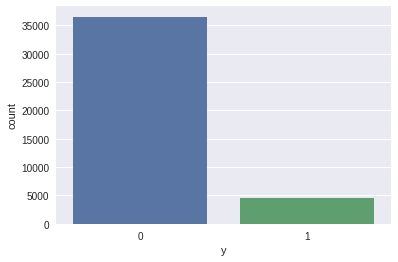

In [0]:
ausgabe = picture.countplot(x='y' , data=data) # Grafig Ausgeben



#Features analysieren

In [0]:
# Display the data types
pd.DataFrame(data.dtypes).T

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,int64,object,object,object,object,object,object,object,object,object,int64,int64,int64,int64,object,float64,float64,float64,float64,float64,int64


In [0]:
data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                   int64
dtype: object

In [0]:
data.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [0]:
#statistische Auswertung
data.select_dtypes(['object']).describe()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563


In [0]:
#statistische Auswertung
data.select_dtypes(['float64', 'int64']).describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.0000,41188.0000,41188.0000,41188.0000,41188.0000,41188.0000,41188.0000,41188.0000,41188.0000,41188.0000,41188.0000
mean,40.0241,258.2850,2.5676,962.4755,0.1730,0.0819,93.5757,-40.5026,3.6213,5167.0359,0.1127
std,10.4212,259.2792,2.7700,186.9109,0.4949,1.5710,0.5788,4.6282,1.7344,72.2515,0.3162
min,17.0000,0.0000,1.0000,0.0000,0.0000,-3.4000,92.2010,-50.8000,0.6340,4963.6000,0.0000
25%,32.0000,102.0000,1.0000,999.0000,0.0000,-1.8000,93.0750,-42.7000,1.3440,5099.1000,0.0000
50%,38.0000,180.0000,2.0000,999.0000,0.0000,1.1000,93.7490,-41.8000,4.8570,5191.0000,0.0000
75%,47.0000,319.0000,3.0000,999.0000,0.0000,1.4000,93.9940,-36.4000,4.9610,5228.1000,0.0000
max,98.0000,4918.0000,56.0000,999.0000,7.0000,1.4000,94.7670,-26.9000,5.0450,5228.1000,1.0000


In [0]:
data.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,
0,39.9112,220.8448,2.6331,984.1139,0.1324,0.2489,93.6038,-40.5931,3.8115,5176.1666
1,40.9131,553.1912,2.0517,792.0356,0.4927,-1.2334,93.3544,-39.7898,2.1231,5095.1160


##leere Felder suchen

In [0]:
leer=data
leer.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

#Personenbezogene Daten

### 1 age
 Alter > numeric

In [0]:
#Feature auslesen	
#Inhhalte von target prüfen
data['age_class']=data['age']

In [0]:
#Feature kategorisieren
data['age_class'] = [90 if (i <= 100)&(i > 90) else i for i in data['age_class']]
data['age_class'] = [90 if (i <= 90)& (i > 80) else i for i in data['age_class']]
data['age_class'] = [80 if (i <= 80)& (i > 70) else i for i in data['age_class']]
data['age_class'] = [70 if (i <= 70)& (i > 60) else i for i in data['age_class']]
data['age_class'] = [60 if (i <= 60)& (i > 50) else i for i in data['age_class']]
data['age_class'] = [50 if (i <= 50)& (i > 40) else i for i in data['age_class']]
data['age_class'] = [40 if (i <= 40)& (i > 30) else i for i in data['age_class']]
data['age_class'] = [30 if (i <= 30)& (i > 20) else i for i in data['age_class']]
data['age_class'] = [20 if (i <= 20)& (i > 10) else i for i in data['age_class']]
data['age_class'] = [1  if (i < 10)& (i >=  0) else i for i in data['age_class']]
data.age_class.head()

0    60
1    60
2    40
3    40
4    60
Name: age_class, dtype: int64

In [0]:
data['age_class'].value_counts() #Inhalte Zählen

40    16385
50    10240
30     7243
60     6270
70      488
80      303
20      140
90      119
Name: age_class, dtype: int64

In [0]:
#Prozentual zeilenweise
test = pd.crosstab(index=data['age_class'], columns=data['y'], margins=False).apply(lambda zeile: zeile/zeile.sum(), axis=1).round(4)*100
test

y,0,1
age_class,,
20,59.2900,40.7100
30,85.2700,14.7300
40,90.2500,9.7500
50,91.8300,8.1700
60,89.3500,10.6500
70,56.5600,43.4400
80,52.8100,47.1900
90,50.4200,49.5800


###2 job 
Beruf > Kategorie

In [0]:
#Prozentual zeilenweise
pd.crosstab(index=data['job'], columns=data['y'], margins=False).apply(lambda zeile: zeile/zeile.sum(), axis=1).round(4)*100

y,0,1
job,,
admin.,87.0300,12.9700
blue-collar,93.1100,6.8900
entrepreneur,91.4800,8.5200
housemaid,90.0000,10.0000
management,88.7800,11.2200
retired,74.7700,25.2300
self-employed,89.5100,10.4900
services,91.8600,8.1400
student,68.5700,31.4300


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff8bbe3c780>,
      dtype=object)

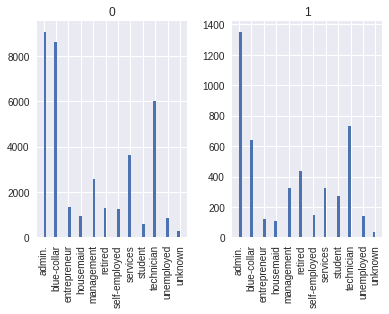

In [0]:
data.hist(column="job",by="y",bins=50)

In [0]:
#Feature auslesen	
data['job_class']=data['job']

#Feature kategorisieren
data['job_class'] = [1 if (i == 'retired') else i for i in data['job_class']]
data['job_class'] = [1 if (i == 'student') else 0 for i in data['job_class']]
data['job_class'].value_counts() #Inhalte Zählen

0    40313
1      875
Name: job_class, dtype: int64

###3 marital
Beziehungsstatus > Kategorie

In [0]:
#Prozentual zeilenweise 
pd.crosstab(index=data['marital'], columns=data['y'], margins=False).apply(lambda zeile: zeile/zeile.sum(), axis=1).round(4)*100

y,0,1
marital,,
divorced,89.6800,10.3200
married,89.8400,10.1600
single,86.0000,14.0000
unknown,85.0000,15.0000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff8baa237f0>,
      dtype=object)

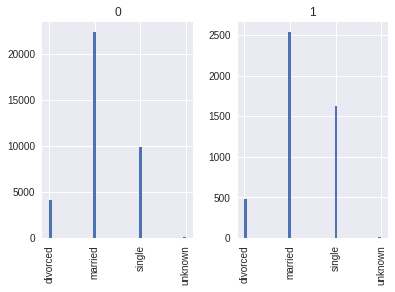

In [0]:
# Grafig Ausgeben > Verhältnis zu y
data.hist(column="marital",by="y",bins=50)


###4 education
Bildung > Kategorie

In [0]:
 #Prozentual zeilenweise 
pd.crosstab(index=data['education'], columns=data['y'], margins=False).apply(lambda zeile: zeile/zeile.sum(), axis=1).round(4)*100

y,0,1
education,,
basic.4y,89.7500,10.2500
basic.6y,91.8000,8.2000
basic.9y,92.1800,7.8200
high.school,89.1600,10.8400
illiterate,77.7800,22.2200
professional.course,88.6500,11.3500
university.degree,86.2800,13.7200
unknown,85.5000,14.5000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff8ba8ef4a8>,
      dtype=object)

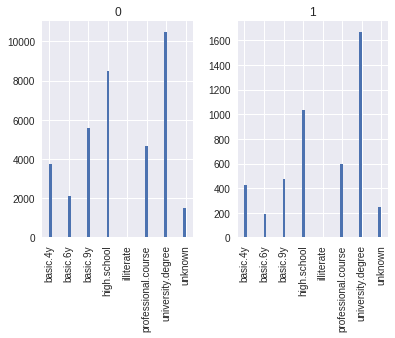

In [0]:
# Grafig Ausgeben > Verhältnis zu y 
data.hist(column="education",by="y",bins=50)

## Grafische Analyse

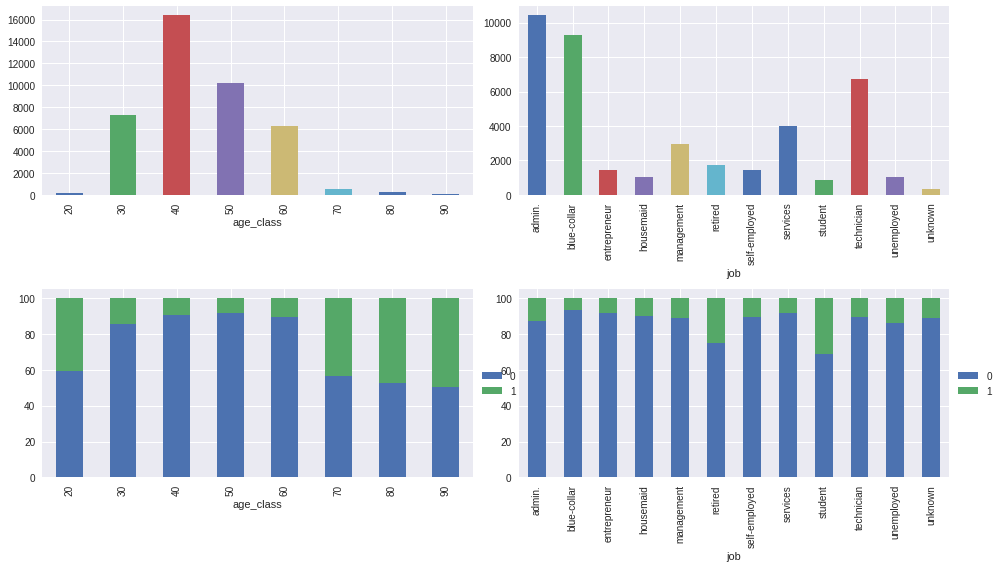

In [0]:
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(231)
data.groupby('age_class').size().plot(kind='bar', ax=ax1)

ax2 = fig.add_subplot(232)
data.groupby('job').size().plot(kind='bar', ax=ax2)


ax3 = fig.add_subplot(234)
data.groupby(['age_class', 'y']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax3)
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax4 = fig.add_subplot(235)
data.groupby(['job', 'y']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax4)
ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.tight_layout()
plt.show()


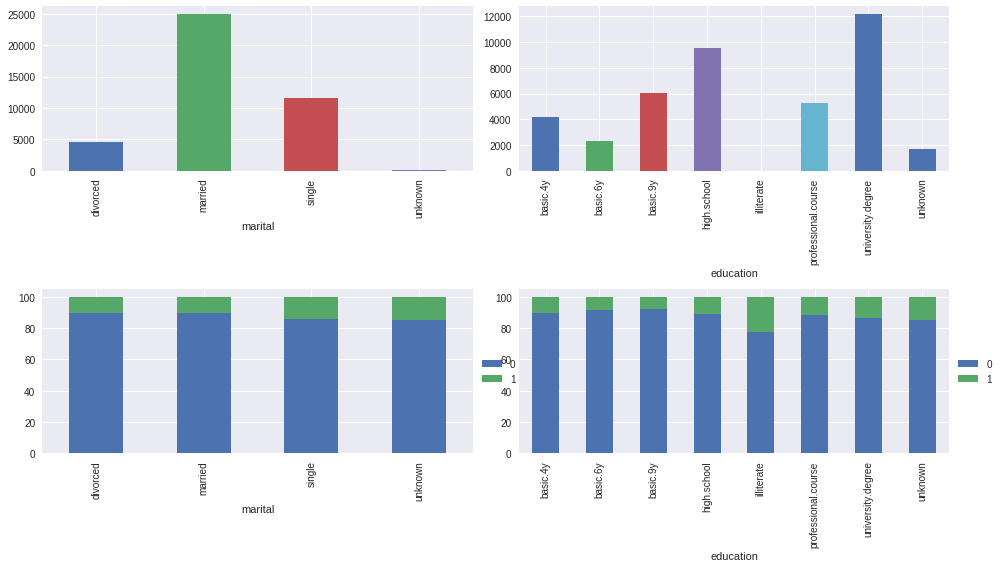

In [0]:
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(231)
data.groupby('marital').size().plot(kind='bar', ax=ax1)

ax2 = fig.add_subplot(232)
data.groupby('education').size().plot(kind='bar', ax=ax2)


ax3 = fig.add_subplot(234)
data.groupby(['marital', 'y']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax3)
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax4 = fig.add_subplot(235)
data.groupby(['education', 'y']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax4)
ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.tight_layout()
plt.show()

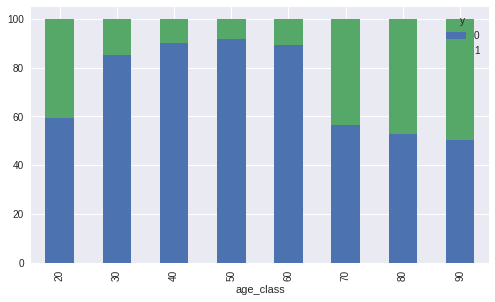

In [0]:
fig = plt.figure(figsize=(20, 8))



ax1 = fig.add_subplot(234)
data.groupby(['age_class', 'y']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax1)
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))



plt.tight_layout()
plt.show()

In [0]:
#Spalte rausnehmen
data.drop(['education'], axis=1, inplace=True)
#Spalte rausnehmen
data.drop(['marital'], axis=1, inplace=True)
#Spalte rausnehmen
data.drop(['job', 'age_class'], axis=1, inplace=True)

# Kundendaten über bestehende Produkte

###5 default
Kreditausfall > Kategorie

In [0]:
#Prozentual zeilenweise 
pd.crosstab(index=data['default'], columns=data['y'], margins=False).apply(lambda zeile: zeile/zeile.sum(), axis=1).round(4)*100


y,0,1
default,,
no,87.1200,12.8800
unknown,94.8500,5.1500
yes,100.0000,0.0000


In [0]:
data['default'].value_counts() #Inhalte Zählen

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

### 6 housing
Immobilienkredit >> Kategorie

In [0]:
 #Prozentual zeilenweise 
pd.crosstab(index=data['housing'], columns=data['y'], margins=False).apply(lambda zeile: zeile/zeile.sum(), axis=1).round(4)*100


y,0,1
housing,,
no,89.1200,10.8800
unknown,89.1900,10.8100
yes,88.3800,11.6200


###7 loan 
Kredit (Darlehn) > Kategorie

In [0]:
 #Prozentual zeilenweise 
pd.crosstab(index=data['loan'], columns=data['y'], margins=False).apply(lambda zeile: zeile/zeile.sum(), axis=1).round(4)*100


y,0,1
loan,,
no,88.6600,11.3400
unknown,89.1900,10.8100
yes,89.0700,10.9300


## grafische Analyse

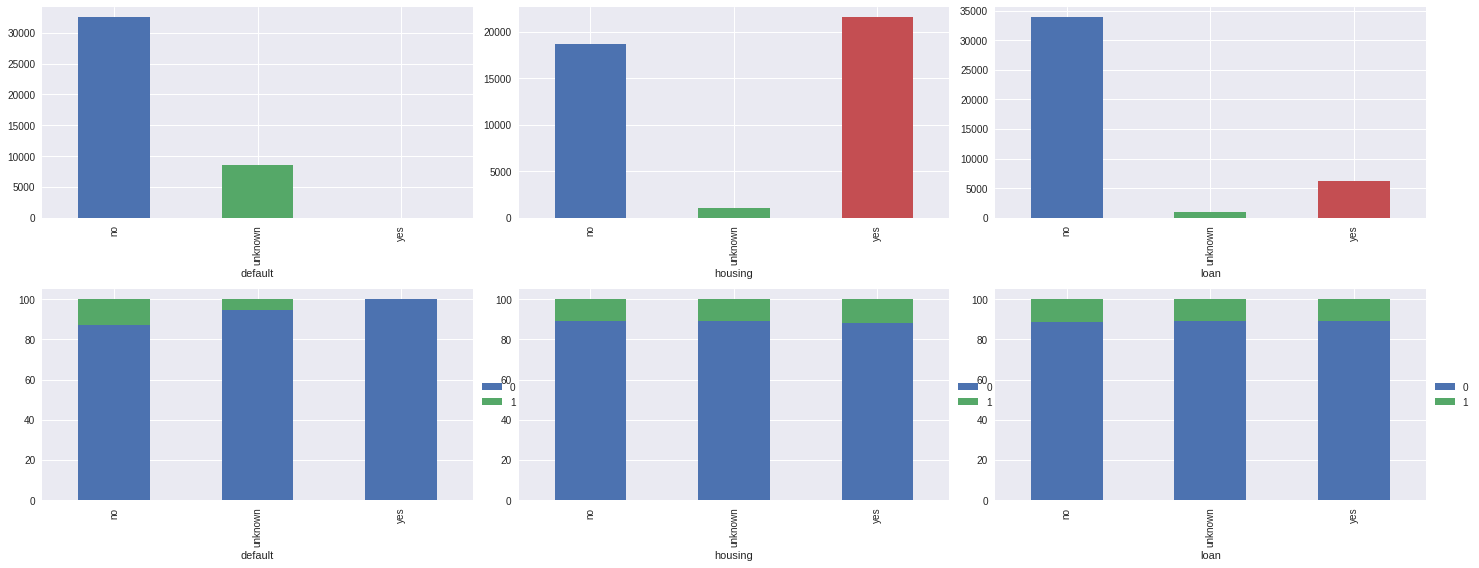

In [0]:
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(231)
data.groupby('default').size().plot(kind='bar', ax=ax1)

ax2 = fig.add_subplot(232)
data.groupby('housing').size().plot(kind='bar', ax=ax2)

ax3 = fig.add_subplot(233)
data.groupby('loan').size().plot(kind='bar', ax=ax3)

ax4 = fig.add_subplot(234)
data.groupby(['default', 'y']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax4)
ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax5 = fig.add_subplot(235)
data.groupby(['housing', 'y']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax5)
ax5.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax6 = fig.add_subplot(236)
data.groupby(['loan', 'y']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax6)
ax6.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [0]:
#Spalte rausnehmen
data.drop(['default', 'housing', 'loan'], axis=1, inplace=True)

# Kundenkontakt

###8 contact
Kontaktart (telefon etc...) > Kategorie

In [0]:
#Prozentual zeilenweise 
pd.crosstab(index=data['contact'], columns=data['y'], margins=False).apply(lambda zeile: zeile/zeile.sum(), axis=1).round(4)*100


y,0,1
contact,,
cellular,85.2600,14.7400
telephone,94.7700,5.2300


In [0]:
#Feature auslesen	
data['contact_class']=data['contact']
#Feature kategorisieren
data['contact_class'] = [1 if (i == 'cellular') else 0 for i in data['contact_class']]
data['contact_class'].value_counts() #Inhalte Zählen


1    26144
0    15044
Name: contact_class, dtype: int64

###9 month
Monat des Kontaktes > Kategorie

In [0]:
 #Prozentual zeilenweise 
pd.crosstab(index=data['month'], columns=data['y'], margins=False).apply(lambda zeile: zeile/zeile.sum(), axis=1).round(4)*100

y,0,1
month,,
apr,79.5200,20.4800
aug,89.4000,10.6000
dec,51.1000,48.9000
jul,90.9500,9.0500
jun,89.4900,10.5100
mar,49.4500,50.5500
may,93.5700,6.4300
nov,89.8600,10.1400
oct,56.1300,43.8700


In [0]:
#Feature auslesen	
data['month_class']=data['month']
#Feature kategorisieren
data['month_class'] = [1 if (i == 'dec') else i for i in data['month_class']]
data['month_class'] = [1 if (i == 'mar') else i for i in data['month_class']]
data['month_class'] = [1 if (i == 'oct') else i for i in data['month_class']]
data['month_class'] = [1 if (i == 'sep') else 0 for i in data['month_class']]
data['month_class'].value_counts() #Inhalte Zählen


0    40618
1      570
Name: month_class, dtype: int64

###10 day_of_week 
Wochentag > Kategorie

In [0]:
 #Prozentual zeilenweise 
pd.crosstab(index=data['day_of_week'], columns=data['y'], margins=False).apply(lambda zeile: zeile/zeile.sum(), axis=1).round(4)*100


y,0,1
day_of_week,,
fri,89.1900,10.8100
mon,90.0500,9.9500
thu,87.8800,12.1200
tue,88.2200,11.7800
wed,88.3300,11.6700


###11 duration
Kontaktdauer in s > Numerisch >





In [0]:
#Feature kategorisieren
data['duration_class']=data['duration']
data['duration_class'] = [1  if (i >=  0    )&(i < 60  )  else i for i in data['duration_class']]
data['duration_class'] = [2  if (i >=  60   )&(i < 120 )  else i for i in data['duration_class']]
data['duration_class'] = [3  if (i >=  120  )&(i < 180 )  else i for i in data['duration_class']]
data['duration_class'] = [4  if (i >=  180  )&(i < 240 )  else i for i in data['duration_class']]
data['duration_class'] = [5  if (i >=  240  )&(i < 300 )  else i for i in data['duration_class']]
data['duration_class'] = [10 if (i >=  300  )&(i < 600 )  else i for i in data['duration_class']]
data['duration_class'] = [15 if (i >=  600  )&(i < 900 )  else i for i in data['duration_class']]
data['duration_class'] = [20 if (i >=  900  )&(i < 1200)  else i for i in data['duration_class']]
data['duration_class'] = [25 if (i >=  1200 )&(i < 1500)  else i for i in data['duration_class']]
data['duration_class'] = [30 if (i >=  1500 )&(i < 1800)  else i for i in data['duration_class']]
data['duration_class'] = [35 if (i >=  1800 )&(i < 2100)  else i for i in data['duration_class']]
data['duration_class'] = [40 if (i >=  2100 )&(i < 2400)  else i for i in data['duration_class']]
data['duration_class'] = [45 if (i >=  2400 )&(i < 2700)  else i for i in data['duration_class']]
data['duration_class'] = [50 if (i >=  2700 )             else i for i in data['duration_class']]
data.duration_class.head(7)


0     5
1     3
2     4
3     3
4    10
5     4
6     3
Name: duration_class, dtype: int64

In [0]:
 #Prozentual zeilenweise 
pd.crosstab(index=data['duration_class'], columns=data['y'], margins=False).apply(lambda zeile: zeile/zeile.sum(), axis=1) .round(4)*100


y,0,1
duration_class,,
1,99.9800,0.0200
2,98.1100,1.8900
3,94.9400,5.0600
4,91.0800,8.9200
5,88.0400,11.9600
10,81.4600,18.5400
15,57.7000,42.3000
20,42.6500,57.3500
25,37.9900,62.0100


###12 campaign
Anzahl Kontakte > numerisch

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff8ba4f4048>,
      dtype=object)

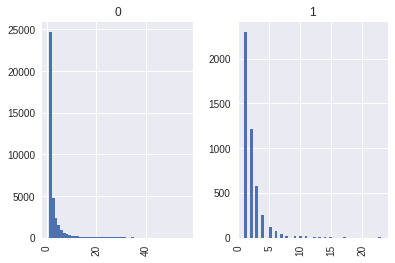

In [0]:
data.hist(column="campaign",by="y",bins=50)

In [0]:
#Prozentual zeilenweise 
pd.crosstab(index=data['campaign'], columns=data['y'], margins=False).apply(lambda zeile: zeile/zeile.sum(), axis=1) .round(4)*100


y,0,1
campaign,,
1,86.9600,13.0400
2,88.5400,11.4600
3,89.2500,10.7500
4,90.6100,9.3900
5,92.5000,7.5000
6,92.3400,7.6600
7,93.9600,6.0400
8,95.7500,4.2500
9,93.9900,6.0100


###13 pdays
Vergangene Tage bis zum Kontakt der letzten campain > Numerisch > 999 = kein vorheriger Kontakt

In [0]:
data['pdays'].value_counts()#Inhalte Zählen

999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
19         3
22         3
21         2
26         1
20         1
25         1
27         1
Name: pdays, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


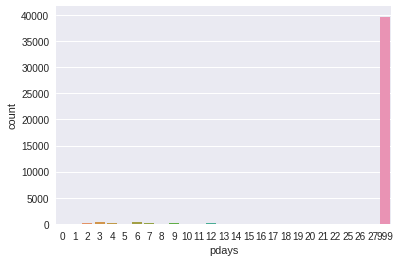

In [0]:
ausgabe = picture.countplot(x='pdays' , data=data) # Grafig Ausgeben


In [0]:
#Feature kategorisieren
data['pdays_class']=data['pdays']
data['pdays_class'] = [1 if (i >= 0)&(i< 999) else 0 for i in data['pdays_class']]

data['pdays_class'].value_counts()


0    39673
1     1515
Name: pdays_class, dtype: int64

In [0]:
data['pdays_class'].count() #Inhalte Zählen

41188

In [0]:
 #Prozentual zeilenweise 
pd.crosstab(index=data['pdays_class'], columns=data['y'], margins=False).apply(lambda zeile: zeile/zeile.sum(), axis=1) .round(4)*100


y,0,1
pdays_class,,
0,90.7400,9.2600
1,36.1700,63.8300


###14 previous
Anzahl vorheriger Kontakte gesammt > Numerisch


In [0]:
 #Prozentual zeilenweise 
pd.crosstab(index=data['previous'], columns=data['y'], margins=False).apply(lambda zeile: zeile/zeile.sum(), axis=1) .round(4)*100


y,0,1
previous,,
0,91.1700,8.8300
1,78.8000,21.2000
2,53.5800,46.4200
3,40.7400,59.2600
4,45.7100,54.2900
5,27.7800,72.2200
6,40.0000,60.0000
7,100.0000,0.0000


###15 poutcome
vorheriges Ergebnis > Kategorie > Ergebnis der vorherigen Campain

In [0]:
 #Prozentual zeilenweise 
pd.crosstab(index=data['poutcome'], columns=data['y'], margins=False).apply(lambda zeile: zeile/zeile.sum(), axis=1) .round(4)*100


y,0,1
poutcome,,
failure,85.7700,14.2300
nonexistent,91.1700,8.8300
success,34.8900,65.1100


In [0]:
#Feature auslesen	
data['poutcome_class']=data['poutcome']
#Feature kategorisieren
data['poutcome_class'] = [0 if (i == 'failure') else i for i in data['poutcome_class']]
data['poutcome_class'] = [0 if (i == 'nonexistent') else 1 for i in data['poutcome_class']]
data['poutcome_class'].value_counts() #Inhalte Zählen


0    35563
1     5625
Name: poutcome_class, dtype: int64

## grafische Analyse

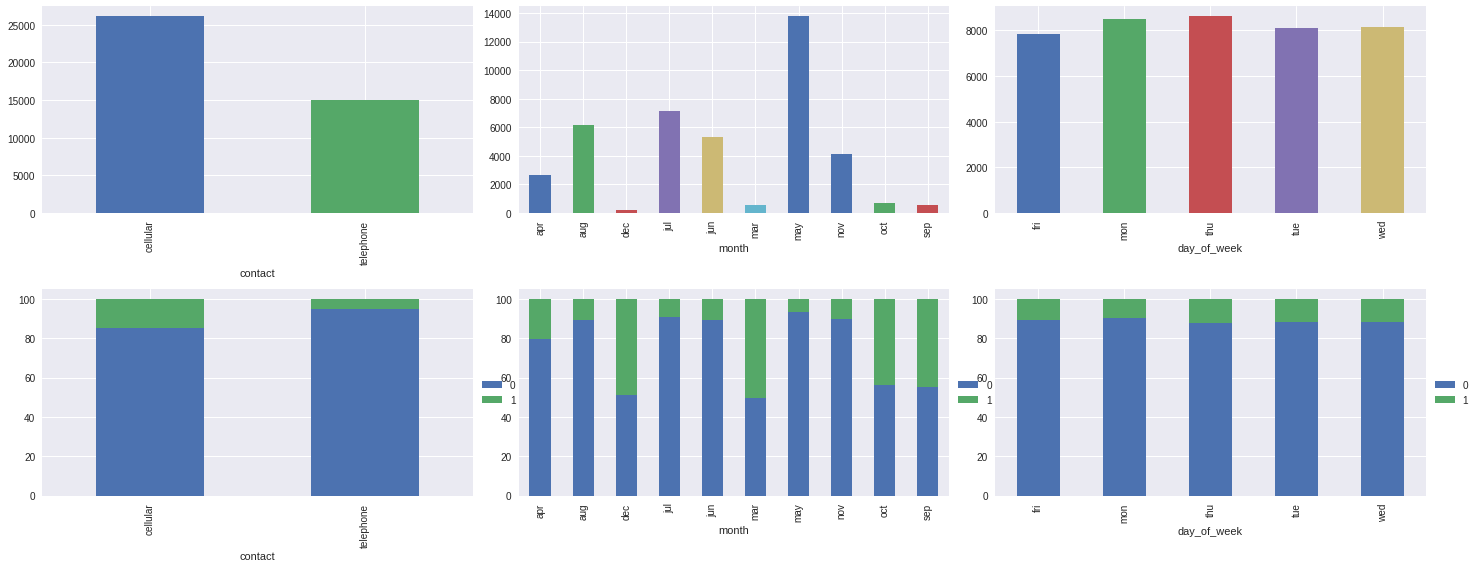

In [0]:
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(231)
data.groupby('contact').size().plot(kind='bar', ax=ax1)

ax2 = fig.add_subplot(232)
data.groupby('month').size().plot(kind='bar', ax=ax2)

ax3 = fig.add_subplot(233)
data.groupby('day_of_week').size().plot(kind='bar', ax=ax3)

ax4 = fig.add_subplot(234)
data.groupby(['contact', 'y']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax4)
ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax5 = fig.add_subplot(235)
data.groupby(['month', 'y']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax5)
ax5.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax6 = fig.add_subplot(236)
data.groupby(['day_of_week', 'y']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax6)
ax6.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

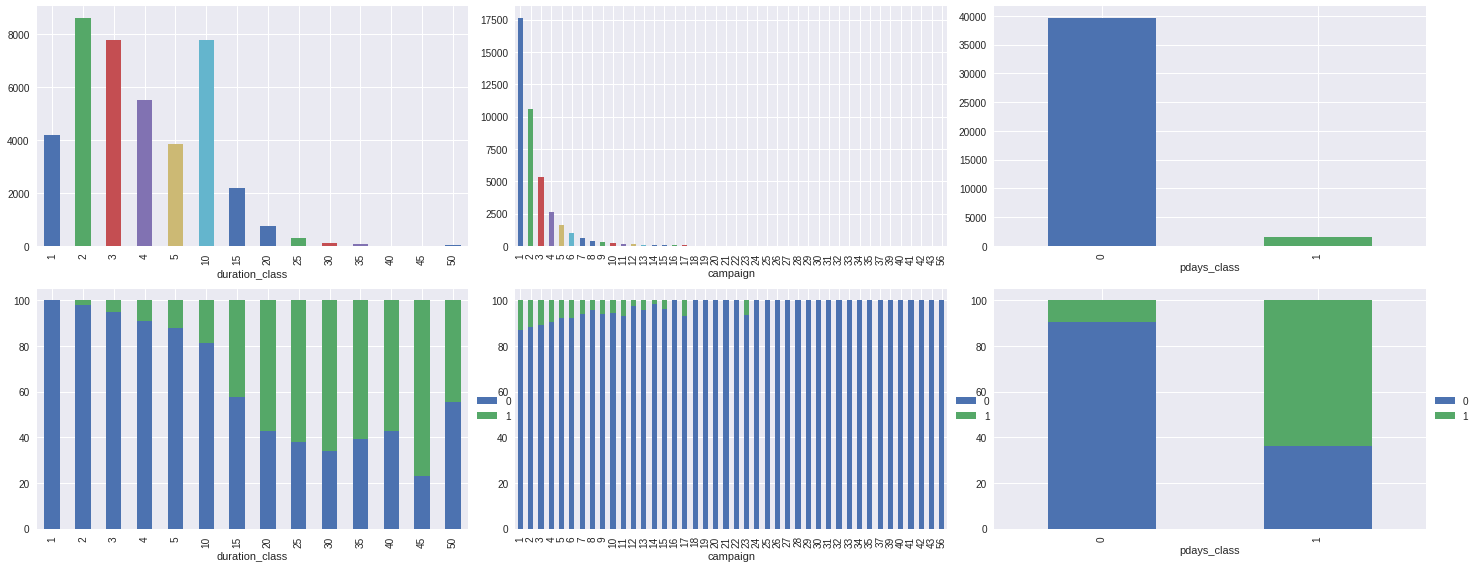

In [0]:
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(231)
data.groupby('duration_class').size().plot(kind='bar', ax=ax1)

ax2 = fig.add_subplot(232)
data.groupby('campaign').size().plot(kind='bar', ax=ax2)

ax3 = fig.add_subplot(233)
data.groupby('pdays_class').size().plot(kind='bar', ax=ax3)

ax4 = fig.add_subplot(234)
data.groupby(['duration_class', 'y']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax4)
ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax5 = fig.add_subplot(235)
data.groupby(['campaign', 'y']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax5)
ax5.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax6 = fig.add_subplot(236)
data.groupby(['pdays_class', 'y']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax6)
ax6.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

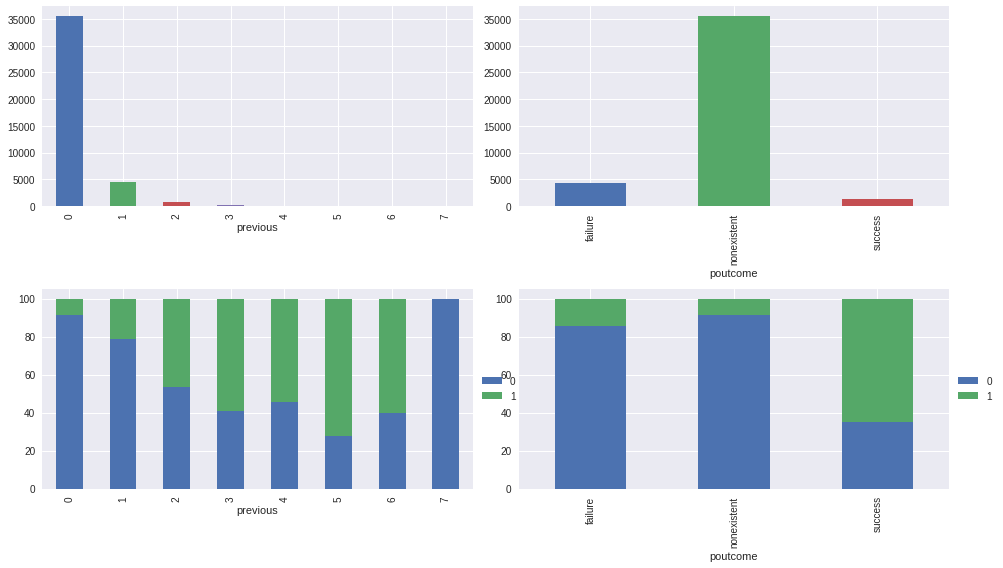

In [0]:
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(231)
data.groupby('previous').size().plot(kind='bar', ax=ax1)

ax2 = fig.add_subplot(232)
data.groupby('poutcome').size().plot(kind='bar', ax=ax2)



ax3 = fig.add_subplot(234)
data.groupby(['previous', 'y']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax3)
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax4 = fig.add_subplot(235)
data.groupby(['poutcome', 'y']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax4)
ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))



plt.tight_layout()
plt.show()

In [0]:
#Spalte rausnehmen
data.drop(['contact','contact_class','campaign', 'month', 'day_of_week' , 'duration', 'pdays','pdays_class', 'poutcome', 'duration_class'  ], axis=1, inplace=True)


# Marktvariablen

###16 emp.var.rate
Beschäftigungsquore? > employment variation rate - quarterly indicator (numeric)

In [0]:
data['emp.var.rate'].unique() #Inhhalte von target prüfen

array([ 1.1,  1.4, -0.1, -0.2, -1.8, -2.9, -3.4, -3. , -1.7, -1.1])

In [0]:
 #Prozentual zeilenweise 
pd.crosstab(index=data['emp.var.rate'], columns=data['y'], margins=False).apply(lambda zeile: zeile/zeile.sum(), axis=1) .round(4)*100


y,0,1
emp.var.rate,,
-3.4000,57.6100,42.3900
-3.0000,48.8400,51.1600
-2.9000,64.2800,35.7200
-1.8000,84.0900,15.9100
-1.7000,47.8700,52.1300
-1.1000,52.6000,47.4000
-0.2000,90.0000,10.0000
-0.1000,93.7000,6.3000
1.1000,96.9100,3.0900


### 17 cons.price.idx
Verbraucher Preis Index > consumer price index - monthly indicator (numeric)


In [0]:
#Feature auslesen	
#Inhhalte von target prüfen
data['cons.price.idx'].unique() 


array([93.994, 94.465, 93.918, 93.444, 93.798, 93.2  , 92.756, 92.843,
       93.075, 92.893, 92.963, 92.469, 92.201, 92.379, 92.431, 92.649,
       92.713, 93.369, 93.749, 93.876, 94.055, 94.215, 94.027, 94.199,
       94.601, 94.767])

In [0]:
 #Prozentual zeilenweise 
pd.crosstab(index=data['cons.price.idx'], columns=data['y'], margins=False).apply(lambda zeile: zeile/zeile.sum(), axis=1) .round(4)*100


y,0,1
cons.price.idx,,
92.2010,65.7100,34.2900
92.3790,60.3000,39.7000
92.4310,59.7300,40.2700
92.4690,62.9200,37.0800
92.6490,52.9400,47.0600
92.7130,48.8400,51.1600
92.7560,90.0000,10.0000
92.8430,55.3200,44.6800
92.8930,90.9600,9.0400


###18 cons.conf.idx
Kunden Vertrauen > consumer confidence index - monthly indicator (numeric)

In [0]:
#Feature auslesen	
#Inhhalte von target prüfen
data['cons.conf.idx'].unique() 


array([-36.4, -41.8, -42.7, -36.1, -40.4, -42. , -45.9, -50. , -47.1,
       -46.2, -40.8, -33.6, -31.4, -29.8, -26.9, -30.1, -33. , -34.8,
       -34.6, -40. , -39.8, -40.3, -38.3, -37.5, -49.5, -50.8])

In [0]:
 #Prozentual zeilenweise 
pd.crosstab(index=data['cons.conf.idx'], columns=data['y'], margins=False).apply(lambda zeile: zeile/zeile.sum(), axis=1) .round(4)*100


y,0,1
cons.conf.idx,,
-50.8000,54.6900,45.3100
-50.0000,55.3200,44.6800
-49.5000,54.4100,45.5900
-47.1000,82.0200,17.9800
-46.2000,90.9600,9.0400
-45.9000,90.0000,10.0000
-42.7000,93.9100,6.0900
-42.0000,94.7500,5.2500
-41.8000,95.7000,4.3000


###19 euribor3m
Referenzzinssatz für Termingelder, zur ermittlung von Krediten > euribor 3 month rate - daily indicator (numeric)

In [0]:
#Feature kategorisieren
data['euribor3m_class']=data['euribor3m']
data['euribor3m_class'] = [1 if (i >0)&(i <= 1.000) else i for i in data['euribor3m_class']]
data['euribor3m_class'] = [2 if (i >1.000)&(i <= 2.000) else i for i in data['euribor3m_class']]
data['euribor3m_class'] = [3 if (i >2.000)&(i <= 3.000) else i for i in data['euribor3m_class']]
data['euribor3m_class'] = [4 if (i >3.000)&(i <= 4.000) else i for i in data['euribor3m_class']]
data['euribor3m_class'] = [5 if (i >4.000)             else i for i in data['euribor3m_class']]
data.euribor3m_class.head()


0   5.0000
1   5.0000
2   5.0000
3   5.0000
4   5.0000
Name: euribor3m_class, dtype: float64

In [0]:
#Feature auslesen	
#Inhhalte von target prüfen
data['euribor3m_class'].unique() 


array([5., 4., 2., 1.])

In [0]:
#Feature mit target in verbindung setzen
pd.crosstab(data.y, data.euribor3m)


euribor3m,0.634,0.635,0.636,0.637,0.638,0.639,0.64,0.642,0.643,0.644,0.645,0.6459999999999999,0.649,0.65,0.6509999999999999,0.652,0.653,0.654,0.655,0.659,0.6629999999999999,0.6679999999999999,0.672,0.677,0.682,0.6829999999999999,0.684,0.685,0.688,0.69,0.6920000000000001,0.695,0.6970000000000001,0.6990000000000001,0.7,0.701,0.7020000000000001,0.7040000000000001,0.706,0.7070000000000001,0.708,0.7090000000000001,0.71,0.711,0.7120000000000001,0.713,0.7140000000000001,0.715,0.716,0.7170000000000001,0.718,0.7190000000000001,0.72,0.721,0.722,0.723,0.7240000000000001,0.727,0.728,0.7290000000000001,0.73,0.731,0.732,0.733,0.735,0.737,0.7390000000000001,0.74,0.741,0.742,0.743,0.7440000000000001,0.748,0.7490000000000001,0.75,0.752,0.753,0.754,0.755,0.7609999999999999,0.762,0.7659999999999999,0.767,0.768,0.77,0.7709999999999999,0.773,0.778,0.7809999999999999,0.782,0.7879999999999999,0.79,0.7929999999999999,0.797,0.802,0.8029999999999999,0.809,0.81,0.813,0.8190000000000001,0.821,0.8220000000000001,0.825,0.8270000000000001,0.8290000000000001,0.8340000000000001,0.835,0.838,0.84,0.843,0.846,0.8490000000000001,0.851,0.8540000000000001,0.8590000000000001,0.861,0.8690000000000001,0.87,0.873,0.8759999999999999,0.877,0.878,0.879,0.88,0.8809999999999999,0.882,0.883,0.884,0.885,0.8859999999999999,0.888,0.889,0.89,0.8909999999999999,0.893,0.894,0.895,0.8959999999999999,0.898,0.899,0.9,0.903,0.904,0.905,0.9079999999999999,0.914,0.9209999999999999,0.927,0.9329999999999999,0.937,0.9420000000000001,0.9440000000000001,0.953,0.956,0.9590000000000001,0.965,0.9690000000000001,0.972,0.977,0.9790000000000001,0.982,0.985,0.987,0.993,0.996,1.0,1.0070000000000001,1.008,1.016,1.018,1.025,1.028,1.0290000000000001,1.03,1.031,1.032,1.035,1.037,1.0390000000000001,1.04,1.041,1.043,1.044,1.045,1.046,1.047,1.048,1.0490000000000002,1.05,1.0590000000000002,1.072,1.085,1.099,1.206,1.215,1.224,1.235,1.244,1.25,1.252,1.2590000000000001,1.26,1.262,1.264,1.266,1.268,1.27,1.281,1.286,1.291,1.2990000000000002,1.3130000000000002,1.327,1.334,1.344,1.354,1.365,1.3719999999999999,1.3840000000000001,1.392,1.4,1.405,1.406,1.41,1.415,1.423,1.435,1.445,1.453,1.466,1.479,1.483,1.4980000000000002,1.51,1.52,1.531,1.538,1.548,1.556,1.56,1.574,1.584,1.6019999999999999,1.614,1.629,1.64,1.65,1.663,1.6869999999999998,1.703,1.726,1.757,1.778,1.7990000000000002,1.811,3.053,3.282,3.3289999999999997,3.428,3.488,3.563,3.6689999999999996,3.7430000000000003,3.8160000000000003,3.853,3.8789999999999996,3.9010000000000002,4.021,4.0760000000000005,4.12,4.1530000000000005,4.191,4.223,4.245,4.2860000000000005,4.343,4.406000000000001,4.474,4.592,4.663,4.7,4.7330000000000005,4.76,4.794,4.827,4.855,4.856,4.857,4.8580000000000005,4.859,4.86,4.864,4.865,4.8660000000000005,4.912,4.918,4.921,4.936,4.947,4.955,4.956,4.957,4.958,4.959,4.96,4.961,4.962,4.963,4.9639999999999995,4.965,4.966,4.967,4.968,4.97,5.0,5.045
y,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2,21,11,1,2,5,5,18,12,14,15,26,4,8,4,8,6,7,10,5,7,9,9,5,19,3,6,4,0,1,5,3,4,14,4,8,13,2,7,15,2,4,5,3,6,7,66,50,32,11,13,27,31,2,45,4,18,2,19,5,10,12,4,5,8,12,56,32,22,49,10,12,7,1,5,4,5,27,1,11,1,2,7,9,7,5,12,3,12,8,7,4,6,21,2,22,14,9,3,17,17,7,21,12,6,9,6,19,7,13,7,19,15,19,20,42,32,1,62,15,8,21,96,9,43,18,86,78,1,25,5,11,8,4,7,3,2,16,26,15,7,4,28,5,11,3,1,2,0,2,7,2,2,1,6,4,1,10,16,3,9,2,13,3,1,10,1,2,6,2,4,6,27,4,3,7,2,2,6,3,5,3,21,1,6,1,17,7,13,13,17,3,8,7,16,5,4,385,527,19,49,150,95,65,716,55,89,574,9,503,495,468,505,450,369,158,167,7,8,15,9,1034,15,227,73,61,65,83,73,49,58,43,29,8,12,15,12,1,7,4,1,1,3,6,9,6,3,10,13,6,2,13,1,4,19,0,1,1,1,1,2,1,1,1,1,2,1,639,772,713,671,591,1,7,5,3,5,1,2,5,5,2,1,1,2,819,1178,2796,704,758,854,991,358,326,3,2,1,1,94,96,23,484,546,858,956,1812,2469,2361,1120,100

###20 nr.employed
Anzahl von angestellten > number of employees - quarterly indicator (numeric)

In [0]:
 #Prozentual zeilenweise 
pd.crosstab(index=data['nr.employed'], columns=data['y'], margins=False).apply(lambda zeile: zeile/zeile.sum(), axis=1) .round(4)*100


y,0,1
nr.employed,,
4963.6000,52.6000,47.4000
4991.6000,47.8700,52.1300
5008.7000,43.2300,56.7700
5017.5000,57.6100,42.3900
5023.5000,48.8400,51.1600
5076.2000,64.2800,35.7200
5099.1000,87.2000,12.8000
5176.3000,90.0000,10.0000
5191.0000,96.9100,3.0900


##grafische Analyse

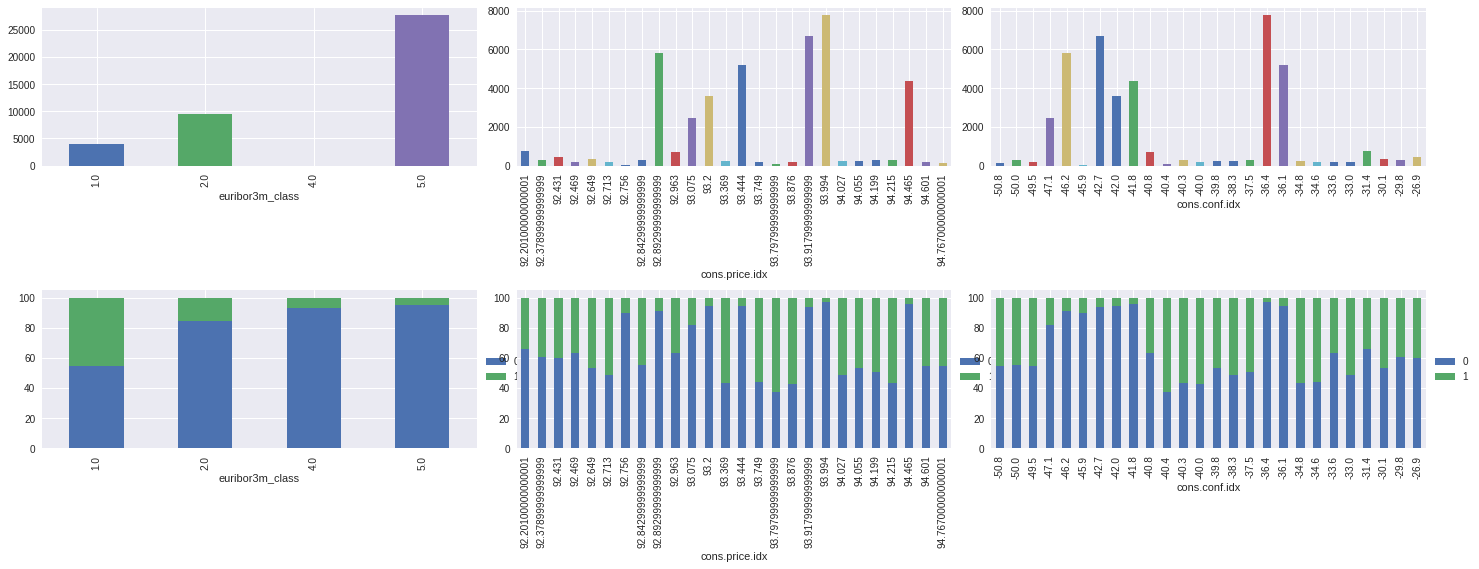

In [0]:
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(231)
data.groupby('euribor3m_class').size().plot(kind='bar', ax=ax1)

ax2 = fig.add_subplot(232)
data.groupby('cons.price.idx').size().plot(kind='bar', ax=ax2)

ax3 = fig.add_subplot(233)
data.groupby('cons.conf.idx').size().plot(kind='bar', ax=ax3)

ax4 = fig.add_subplot(234)
data.groupby(['euribor3m_class', 'y']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax4)
ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax5 = fig.add_subplot(235)
data.groupby(['cons.price.idx', 'y']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax5)
ax5.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax6 = fig.add_subplot(236)
data.groupby(['cons.conf.idx', 'y']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax6)
ax6.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

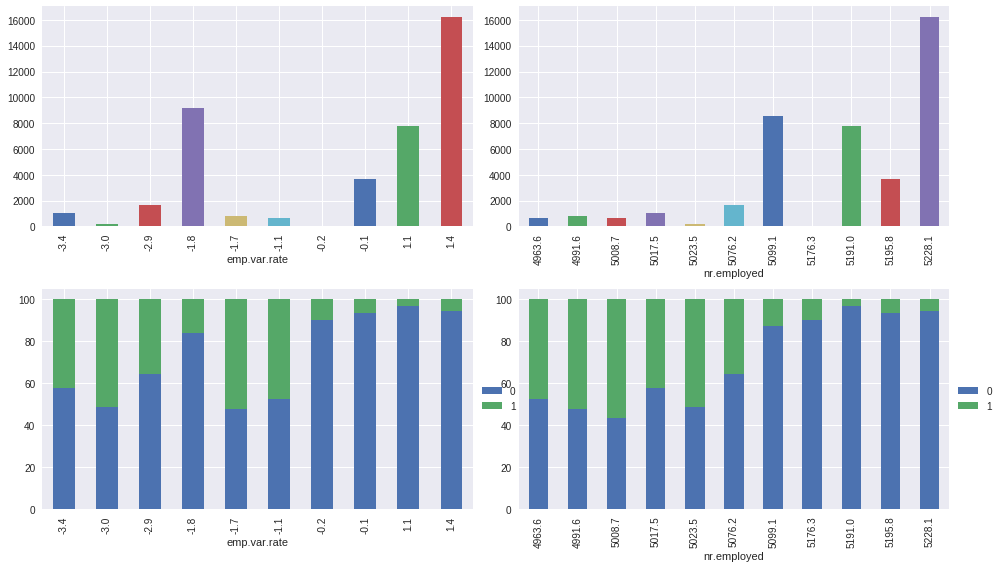

In [0]:
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(231)
data.groupby('emp.var.rate').size().plot(kind='bar', ax=ax1)

ax2 = fig.add_subplot(232)
data.groupby('nr.employed').size().plot(kind='bar', ax=ax2)



ax3 = fig.add_subplot(234)
data.groupby(['emp.var.rate', 'y']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax3)
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax4 = fig.add_subplot(235)
data.groupby(['nr.employed', 'y']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax4)
ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))



plt.tight_layout()
plt.show()

In [0]:
#Spalte rausnehmen
data.drop(['euribor3m_class', 'emp.var.rate'], axis=1, inplace=True)


#Auswahl Features

# Features umwandeln

**bold text**##### One-Hot-Encoding  # für regression aber nur categories age z.B. ist schon ein Numerischer Zeitwert und kann übernommen werden

In [0]:
data.dtypes

age                 int64
previous            int64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                   int64
job_class           int64
month_class         int64
poutcome_class      int64
dtype: object

#Normalization

Standard Scaling # alle nichtskallierten Daten werden genommen auser die gedropten wie age, um die ausreisser zu minimieren.

In [0]:
#normalized_numerical_feature_names = []
#for numeric_feature in list(data.select_dtypes(['int64', 'float64']).drop(['age'], axis=1).columns[0:5]):
   # scaler = StandardScaler()
   # feature_name = f'norm_{numeric_feature}'
   # data[feature_name] = scaler.fit_transform(data[[numeric_feature]].values)
   # normalized_numerical_feature_names.append(feature_name)

#Logistic Regression

## Data Zuordnung Achsen

Features:

'age'
'job_class'   
contact_class 
 'month_class'
'poutcome_class'
emp.var.rate 
'nr.employed'   

  cons.price.idx'    
'cons.conf.idx'    
            
         
    'euribor3m'    
       
      

                


In [0]:
x, y = data        [[
'age',
'month_class',
'job_class',
'poutcome_class',
'nr.employed'
    
   
]].values, data['y'].values 


#daten in Matrix packen, pro [] eine Array inszanz also [[]] 2 Dimensoon Matrix, .values um in matrix zu wandeln

In [0]:
x.shape

(41188, 5)

In [0]:
x.real


array([[5.6000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.1910e+03],
       [5.7000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.1910e+03],
       [3.7000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.1910e+03],
       ...,
       [5.6000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9636e+03],
       [4.4000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9636e+03],
       [7.4000e+01, 0.0000e+00, 0.0000e+00, 1.0000e+00, 4.9636e+03]])

In [0]:
y.shape

(41188,)

In [0]:
y.real

array([0, 0, 0, ..., 0, 1, 0])

## Training with Logistic Regression with Stochastic Gradient Descent

In [0]:
# Set Seed for "Deterministic Randomness".
#np.random.seed(1909) #lieber weglassen

# Initialize the Logisitc Regression Model.-
logistic_model = SGDClassifier(loss='log', 
                               eta0=0.001, #schrittlänge um min Punkt zu finden und nicht versehendlich zu übergehen
                               alpha=0.03, #wie stark die loss funktion gewichtet wird (bestrafung der Modellkomplexität)
                               max_iter=1000, # anzahl d. itterationsschritte begrenzen, determinator
                               random_state=8765) #hier lieber random_state setzen

# Perform the Learning.
logistic_model.fit(x, y) #fit = setze eine gerade oder eine ebene an...

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGDClassifier(alpha=0.03, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=8765, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
# Perform the Prediction for a student has been sleeping 20 hours and has been learning 8 hours.
y_pred = logistic_model.predict([[30,1,1,4,6,5,3,8,1]])
y_pred_probabilities = logistic_model.predict_proba([[30,1,1,4,6,5,3,8,1]])

ValueError: ignored

In [0]:
print('Ergebniss')



# Predict class probabilities for a student who has slept 20 hours and has learnt 8 hours.
print(f'- kauft nicht: {y_pred_probabilities[0][0] * 100:.2f}%')
print(f'- kauft: {y_pred_probabilities[0][1] * 100:.2f}%')

#Evaluation

##Holdout Method

einen teil zum testen weglassen

In [0]:
# Set Seed for "Deterministic Randomness".
np.random.seed(7845789)

# Train-Test-Split with 75% for Training and 25% for Testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

# Perform the Learning
logistic_model.fit(x_train, y_train)

In [0]:
# Perform the Prediction on the Test-Set-Features.
y_pred = logistic_model.predict(x_test)
y_pred_probabilities = logistic_model.predict_proba(x_test)

In [0]:
# Calculating various performance measures.
accuracy0 = accuracy_score(y_test, y_pred)
precision0 = precision_score(y_test, y_pred)
recall0 = recall_score(y_test, y_pred)
f10 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy0 * 100:.2f}%')    # trefferchance, acc + f1 nah = balanded wenn nicht nah dann imbalanced 
print(f'Precision: {precision0 * 100:.2f}%')  # vorhersage
print(f'Recall: {recall0 * 100:.2f}%')        # 
print(f'F1: {f10 * 100:.2f}%')                #

##10-Fold Chross_Validation

In [0]:
# Set seed for "deterministic randomness".
np.random.seed(1909)

# Initialize 10-Fold-Cross-Validation.
k_fold = KFold(n_splits=10)  #teile in 10 gleich große teile

# Empty lists for persisting the performances measures calculated in each iteration. 
accuracies = []
precisions = []
recalls = []
f1s = []

#schleife, alles was eingerückt ist gehört dazu

for train_idx, test_idx in k_fold.split(x):
  # Split dataset into a train and test set.
  x_train, x_test = x[train_idx], x[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]
  
  # Run the logistic regression on the current training set.
  logistic_model = SGDClassifier(loss='log', eta0=0.001, alpha=0.03, max_iter=1000)
  logistic_model.fit(x_train, y_train)
  
  # Perform the Prediction on the Test-Set-Features.
  y_pred = logistic_model.predict(x_test)
  y_pred_probabilities = logistic_model.predict_proba(x_test)
  
  # Calculate the performance measures on the current test set.
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  
  # Append to performances measures to lists.
  accuracies.append(accuracy)
  precisions.append(precision)
  recalls.append(recall)
  f1s.append(f1)

In [0]:
print(f'Average accuracy: {np.mean(accuracies) * 100:.2f}%') #np.mean = mittelwert
print(f'Average precision: {np.mean(precisions) * 100:.2f}%')
print(f'Average recall: {np.mean(recalls) * 100:.2f}%')
print(f'Average F1: {np.mean(f1s) * 100:.2f}%')

## StratifiedKFold

In [0]:
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(x, y)
# Initialize StratifiedKFold
StratifiedKFold(n_splits=2, random_state=5468, shuffle=True)  #teile in x teile

# Empty lists for persisting the performances measures calculated in each iteration. 
accuracies2 = []
precisions2 = []
recalls2 = []
f1s2 = []

#schleife, alles was eingerückt ist gehört dazu

print(skf)  
StratifiedKFold(n_splits=2, random_state=16543, shuffle=False)
for train_index, test_index in skf.split(x, y):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  
  
  
  # Run the logistic regression on the current training set.
  logistic_model = SGDClassifier(loss='log', eta0=0.001, alpha=0.02, max_iter=5000)
  logistic_model.fit(x_train, y_train)
  
  # Perform the Prediction on the Test-Set-Features.
  y_pred = logistic_model.predict(x_test)
  y_pred_probabilities = logistic_model.predict_proba(x_test)
  
  # Calculate the performance measures on the current test set.
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  
  # Append to performances measures to lists.
  accuracies2.append(accuracy)
  precisions2.append(precision)
  recalls2.append(recall)
  f1s2.append(f1)

In [0]:
print(f'Average accuracy: {np.mean(accuracies2) * 100:.2f}%') #np.mean = mittelwert
print(f'Average precision: {np.mean(precisions2) * 100:.2f}%')
print(f'Average recall: {np.mean(recalls2) * 100:.2f}%')
print(f'Average F1: {np.mean(f1s2) * 100:.2f}%')

##Basic Literature

Moro S., Laureano, R., & Cortez, P. (2011). Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. In P. Novais et al, Proceedings of the European Simulation and Modelling Conference. Paper presented at the 2011 European Simulation and Modelling Conference, Guimaraes, Portugal (117-121). Belgium: EUROSIS.
Moro S., Cortez, P., & Rita, P. (2004). A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, 62, 22-31. https://doi.org/10.1016/j.dss.2014.03.001

##Source

https://archive.ics.uci.edu/ml/datasets/Bank+Marketing